# Embedded Methods
## Adaptive-Runge–Kutta


I show here how the Runge–Kutta-Fehlberg method works. I'll implement a general
RKF solver, in which one can give the parameters of *any* stage and order method
and run it. Once I finish understanding it, I'll implement RKF45, and then more!

I found this [lecture](https://www.math.usm.edu/lambers/mat461/lecture4.pdf)
and this [post](https://scicomp.stackexchange.com/questions/32563/dormand-prince-54-how-to-update-the-stepsize-and-make-accept-reject-decision) useful.

selfThe explicit Runge–Kutta (RK) method can be made, efficiently, adaptive. This is done
by the so-called embedded methods, which basically involves the calculation of each step
by two different solvers, and adapting the step-size until their difference is below some acceptable
value. The proceedure is similar to the classical RM methods (one of order $p$ and the other $p+1$).

Lets assume that we have a differential equation
$$
\dfrac{d\vec{y}}{dt}=f(\vec{y},t) \;,
$$
with  given $\vec{y}(0)$ (as always $t \in [0,1]$). We follow the iteration:[$^1$](#1)

$$
\vec{y}_{n+1}=\vec{y}_{n}+ h\sum_{i=1}^{s} b_i \vec{k}_i \\
\vec{y}^{\star}_{n+1}=\vec{y}_{n}+ h\sum_{i=1}^{s} b_i^{\star} \vec{k}_i \;,
$$
with
$$
\vec{k}_{i}=\vec f\Bigg(\vec{y}_{n}+h \Big(\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j} \Big), t_{n}+h c_{i}   \Bigg)\;.
$$

Having the two estimates for the next step, we can estimate the error 

$$
\epsilon \equiv \left|\vec{y}_{n+1}- \vec{y}^{\star}_{n+1} \right|
$$

Then, if $\epsilon \geq \epsilon_0$ ($\epsilon_0$ is some desirable error), we adjust the stepsize as[$^2$](#footnote2)

$$ 
h \to \beta h \left (h\dfrac{\epsilon_0}{\epsilon} \right)^{1/p} \;,
$$

and calculate again $\vec{y}_{n+1}$ and $\vec{y}_{n+1}^{\star}$ until  $\epsilon < \epsilon_0$.
When $\epsilon < \epsilon_0$, we accept $y_{n+1}$ ($y_{n+1}^{\star}$ is just for stepsize control!),
we increase the stepsize a bit

$$ 
h \to \beta h \left (\dfrac{\epsilon_0}{\epsilon} \right)^{1/(p+1)} \;,
$$

and move to the next step.


A better step update would be to use 
$$err = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\frac{y_{n+1 ,i}-y^{\star}_{n+1 ,i}}{sc}\right)^{2}}$$
with
$$sc_i = Atol + \max\left(|y_{n+1, i}|,|y^{\star}_{n+1 ,i}|\right)\; Rtol.$$
where Atol, and Rtol are user inputs. Then you change
$$h \to \beta \; h \;  \left(\frac{1}{err}\right)^{\frac{1}{p+1}}.$$
You can also restrict the increase by
$$h \to \beta \; h \;  min\left[\left(\frac{1}{err}\right)^{\frac{1}{p+1}}, f_{max}\right],$$
with $f_{max}$ input that restricts how much we are allowed to increase $h$.

$$\begin{array}{}
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
\hline
\end{array}$$ 
<span id="footnote1">$^1$ </span>Butcher tableau in this case is written as

$$
\begin{array}{c|cccc}
0      & 0      &   0   &      0& \dots & 0& 0\\
c_2    & a_{21} &   0   &   0   & \dots & 0& 0\\
c_3    & a_{31} & a_{32}&      0& \dots & 0& 0\\
\vdots & \vdots & \vdots& \vdots&\ddots &\ddots& \vdots\\
c_s    & a_{s1} & a_{s2}& a_{s3}& \dots & a_{s s-1}& 0 \\
\hline
 p      & b_1    & b_2  & b_3 & \dots & b_{s-1} & b_s \\
 p+1      & b_1^{\star}    & b_2^{\star}  & b_3^{\star} & \dots & b_{s-1}^{\star} & b_s^{\star}
\end{array}
$$



<span id="footnote2">$^2$ </span>
Note that $\beta \approx 1$ is an input parameter used to adjust
the aggresiveness of the changes in h.


### RKF in pseudo-code
In an algorithmic way, the RKF method can be written as:

```bash
Inputs-> system_eqs=dydt, initial_condition=y0, No_equations=Neqs, initial_step_size=h0, 
            minimum_step_size=hmin, maximum_step_size=hmax, maximum_No_steps=Nsteps, 
            absolute_tolerance=eps_abs, beta=b, method=RKpq
#Initializations
tn=0

#allocate lists we will need: 
Define k[Neqs][s], ak[Neqs], bk[Neqs], bstark[Neqs], ynext[Neqs], ynext_star[Neqs], yn[Neqs],

#Allow steps and solution to be arrays with maximum number of steps (or use dynamic arrays or something)
Define steps[Nsteps], solution[Neqs][Nsteps] 
        


for eq in [1,2,...,Neq]
    yn[eq]=y0[eq]
    ynext[eq]=0
    ynext_star[eq]=0
    delta[eq]=0

h=h0

while tn<1 and step<Nsteps do
    step=step+1#current step
    h_stop=True#change to False when you find a suitable h
    
    while h_stop do
        #calculate \vec{k}
        for stage in [1,2...,s] do
            for eq in [1,2...,Neqs] do
                ak[eq]=sum(a[j,i]*k[i], i in [1,...,stage-1] )
            done

            for eq in [1,2,...,Neq] do
                self.k[eq][stage]=dydt( sum(yn[i] +_ak[i], i in [1,2,...,Neqs]) ,tn+ c[stage]*h)[eq]
            done
        done

        #calculate \vec{y}_{n+1} and \vec{y}_{n+1}_{\star}
        ## first calculate sum b*k         
        for eq in [1,2,...,Neqs]do
            bk[eq]=sum(b[i]*k[eq][i]*h, i in [1,2,...,s])
            bstark[eq]=sum(bstar[i]*k[eq][i]*h, i in [1,2,...,s])
        done


        for eq in [1,2,...,Neqs]do
            ynext[eq]=yn[eq]+ bk[eq]
            ynext_star[eq]=yn[eq]+ bstark[eq]
            delta[eq]=ynext[eq]-ynext_star[eq]
            
        done
        
        
               
        #adjust h. There are more refined ways to do this, but this is a start.  
        ##################################################################################################
        
        #define a scale
        for eq in [1,2,...,Neqs]do
            scale[eq]=abs_tol+rel_tol*max(abs(ynext[eq]),abs(ynext_star[eq]))
        done
        
        Delta=sqrt(1/Neqs*( sum(delta/scale)^2 ) )
        
        
        if(Delta<1):
            h_stop=False 
            
     
        fac=min( 1/delta^1/(p+1)  , fac_max );
            
        h= beta*h0*fac 
        
        
        #if you have limits apply them
        if h>hmax then    
            h=hmax
        fi
        
        if h<hmin then
            h=hmin
        fi
        
        #don't let the next tn>1
        if tn+h>1 then
            h=1-tn
        fi
        
        h0=h
        ##################################################################################################
    done
    
    
    for eq in [1,2,...,Neqs] do
        yn[eq]=ynext[eq]
        solution[eq][step]=yn[eq]
    done
        
    tn=tn+h
   
    steps[step]=tn
    
done

return steps, solution

#note that for error monitoring, it may be useful to return an
#array with the errors and stepsize at each step.
```



The Dormand-Prince has a Butcher tableau (got it from <a href=http://runge.math.smu.edu/arkode_dev/doc/guide/build/html/Butcher.html> here</a>)

\begin{array}{r|ccccccc}
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  \frac{1}{5} & \frac{1}{5} & 0 & 0 & 0 & 0 & 0 & 0 \\
  \frac{3}{10} & \frac{3}{40} & \frac{9}{40} & 0 & 0 & 0 & 0 & 0 \\
  \frac{4}{5} & \frac{44}{45} & -\frac{56}{15} & \frac{32}{9} & 0 & 0 & 0 & 0 \\
  \frac{8}{9} & \frac{19372}{6561} & -\frac{25360}{2187} & \frac{64448}{6561} & -\frac{212}{729} & 0 & 0 & 0 \\
  1 & \frac{9017}{3168} & -\frac{355}{33} & \frac{46732}{5247} & \frac{49}{176} & -\frac{5103}{18656} & 0 & 0 \\
  1 & \frac{35}{384} & 0 & \frac{500}{1113} & \frac{125}{192} & -\frac{2187}{6784} & \frac{11}{84} & 0 \\
  \hline
  5 & \frac{35}{384} & 0 & \frac{500}{1113} & \frac{125}{192} & -\frac{2187}{6784} & \frac{11}{84} & 0 \\
  4 & \frac{5179}{57600} & 0 & \frac{7571}{16695} & \frac{393}{640} & -\frac{92097}{339200} & \frac{187}{2100} & \frac{1}{40}
\end{array}

In [1]:
import numpy as np

import matplotlib
# matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
# %matplotlib widget

import matplotlib.pyplot as plt

plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=10
plt.rcParams['mathtext.fontset']='stixsans'

In [2]:
class DormandPrince:
    def __init__(self):
        self.s=7
        self.p=4
        self.c=[0,1/5.,3/10.,4/5.,8/9.,1.,1.]
        self.b=[5179/57600.,0,7571/16695.,393/640.,-92097/339200.,187/2100.,1/40.]
        self.bstar=[ 35/384.,0.,500/1113.,125/192.,-2187/6784.,11/84.,0 ]
        self.a=[ [0 for j in range(self.s)] for i in range(self.s)]
        
        self.a[6][0]=35/384.
        self.a[6][1]=0
        self.a[6][2]=500/1113.
        self.a[6][3]=125/192.
        self.a[6][4]=-2187/6784.
        self.a[6][5]=11/84.
        
        self.a[1][0]=1/5.
        
        self.a[2][0]=3/40.
        self.a[2][1]=9/40.
        
        self.a[3][0]=44/45.
        self.a[3][1]=-56/15.
        self.a[3][2]=32/9.
        
        self.a[4][0]=19372/6561.
        self.a[4][1]=-25360/2187.
        self.a[4][2]=64448/6561.
        self.a[4][3]=-212/729.        
        

        self.a[5][0]=9017/3168.
        self.a[5][1]=-355/33.
        self.a[5][2]=46732/5247.
        self.a[5][3]=49/176.
        self.a[5][4]=-5103/18656.
        
        
        
#define Heun–Euler parameters
class HeunEuler:
    def __init__(self):
        self.s=2
        self.p=1
        self.c=[0,1]
        self.b=[1/2. , 1/2.]
        self.bstar=[1.,0.]
        self.a=[ [0 for j in range(self.s)] for i in range(self.s)]
        self.a[1][0]=1
        
he=HeunEuler()

In [3]:
#the sum of a at each stage should be equal to c.
#the sum of b should be equal to 1.

if False:
    dp=DormandPrince()


    for i,c in enumerate(dp.c):

        print('sum a=',sum(dp.a[i]),', c=',c)
        print('sum b=',sum(dp.b))
        print('sum bstar=',sum(dp.bstar))

        print("----")


In [4]:
class RKF:
    
    '''
    This is a general implementation of explicit RKF solver of
    a system of differential equations in the interval [0,1].
    
    Inputs:
    n_eqs=number of equations to solve
    
    diffeq=an object with overoaded __call__ method (is behaves as a function) which returns 
           the system of dufferential equations to solve. It also has a self.n_eqs attribute
           equal to the number of the equations to be solved.
           
    init_cond= the initial consitions. 

    
    RK_method= an object with attributes s (stage), and Butcher a,b,b_{\star},c parameters, 
               which define the method. 
               
    initial_step_size: Initial step size. Since it is adaptive, we just need to start somewhere.
    This should be of moderate size, and let the algorithm work its magic.
    
    minimum_step_size: The minimum allowed stepsize. This should be something small 
    (of the order of the error we aim)
    
    maximum_step_size: The maximum allowd stepsize. This should be larger that the minimum one.
    
    maximum_No_steps: The maximum number of steps to take. This should be here in order to avoid 
    filling up the RAM. Alternatively, you could print directly to a file, but it would make the code 
    much slower. 
    
    
    absolute_tolerance: Absolute error we aim for.
    
    beta: parameter (with value around 1) that parametrizes the agressiveness of the adaptive process.  
    
    '''
    
    def __init__(self,diffeq,init_cond,RK_method,
                      initial_step_size=1e-3,minimum_step_size=1e-5,maximum_step_size=1e-2,
                      maximum_No_steps=50000,absolute_tolerance=1e-5,relative_tolerance=1e-5,
                      beta=0.85,fac_max=2.):
        
        
        self.tiny=1e-20#define a tiny number. Below this, errors are ignored..
        
        #get all inputs
        self.dydt=diffeq
        self.number_of_eqs=diffeq.n_eqs
        self.h0=initial_step_size
        self.hmin=minimum_step_size
        self.hmax=maximum_step_size
        self.max_N=maximum_No_steps
        self.abs_tol=absolute_tolerance
        self.rel_tol=relative_tolerance
        self.fac_max=fac_max
        self.beta=beta
        
        #get the parameters that define the method
        self.s=RK_method.s
        self.p=RK_method.p
        self.a=RK_method.a
        self.b=RK_method.b
        self.bstar=RK_method.bstar
        self.c=RK_method.c
        
        #initialize arrays
        self.steps=[0]*self.max_N #this is faster than using a for 
        self.k=[0 for i in range(self.number_of_eqs)]#this is initiated to hold all ks
        for eq_i in range(self.number_of_eqs):
            self.k[eq_i]=[0 for i in range(self.s)]
        self.solution=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i]=[0 for i in range(self.max_N)]
            
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i][0]=init_cond[eq_i]#the first step is the initial condition
            
        self.err_n=[0 for i in range(self.max_N)]

        #declare arrays and parameters you are going to need
        #self.ak=[0]*self.number_of_eqs
        #self.bk=[0]*self.number_of_eqs
        #self.bstark=[0]*self.number_of_eqs
        self.ynext=[0]*self.number_of_eqs
        self.ynext_star=[0]*self.number_of_eqs
        self.yn=[0]*self.number_of_eqs
        self.abs_delta=[0]*self.number_of_eqs
        
        
        #initialize a counter
        self.current_step=0
        
        self.end=False# This will be chang to True when the end is reached
        

        

        
        for eq in range(self.number_of_eqs):
            self.yn[eq]=init_cond[eq]
            self.ynext[eq]=0
            self.ynext_star[eq]=0
            #self.abs_delta[eq]=0
        
        self.h_stop=False
        self.h=self.h0
        self.tn=0
        
        
    # function to calculate the \sum_{i=1}^{current stage-1} a_{current stage,i} \vec{k}_{i}*step_size
    def sum_ak(self,stage):
        self.ak=[0]*self.number_of_eqs
        
        for eq_i in range(self.number_of_eqs):
            for i in range(stage-1):
                self.ak[eq_i]+=self.a[stage][i]*self.k[eq_i][i]*self.h
        
        
    
    # function to calculate the \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
    def sum_bk(self):
        self.bk=[0]*self.number_of_eqs
        self.bstark=[0]*self.number_of_eqs
        for eq_i in range(self.number_of_eqs):
            for i in range(self.s):
                self.bk[eq_i]+=self.b[i]*self.k[eq_i][i]*self.h
                self.bstark[eq_i]+=self.bstar[i]*self.k[eq_i][i]*self.h
            

    
    #adjust h. There are more refined ways to do this, but this is a start.  
    def step_control(self):
        _delta=0
        for eq in range(self.number_of_eqs):
            scale=self.abs_tol+self.rel_tol*max(abs( self.ynext[eq] ), abs( self.ynext_star[eq] ))
            _delta+= (self.abs_delta[eq]/scale)**2.
        
        _delta=(1./self.number_of_eqs*_delta)**0.5
        
        if(_delta<1):
            h_stop=False 
            self.err_n[self.current_step]=_delta 
        
        fac=min( (1/_delta) ** 1./(self.p+1)  , self.fac_max );
            
        self.h= self.beta*self.h0*fac 
        
        if self.h>self.hmax:
            self.h=self.hmax
            
        if self.h<self.hmin:
            self.h=self.hmin
        
        #if tn+h becomes larger than 1, set h=1-tn
        if self.tn+self.h>1:
            self.h=1-self.tn
                    
        self.h0=self.h #h0 is redundant, but use it for clarity
                
    def next_step(self):
        '''
        Get the next step.
        '''
        if not (self.tn<1. and self.current_step<self.max_N-1):
            self.end=True 
#             print('end')
        else:
            self.current_step+=1
            
            while True:                
                #this is \vec{k}_1.  
                for eq_i in range(self.number_of_eqs):
                    self.k[eq_i][0]=self.dydt(self.yn,self.tn)[eq_i]

                #once you have \vec{k}_1, find the others.
                for stage in range(1,self.s):
                    #since \sum_{i=1}^{s} a_{stage,i} \vec{k}_{i}*step_size is the same for all 
                    #equations in a given stage, call here self.sum_ak
                    self.sum_ak(stage)
                    #get a d\vec{y}/dt needed for \vec_{k}_{stage}
                    _tmp_sum=[self.yn[i] + self.ak[i] for i in range(self.number_of_eqs) ]
                    _dydt=self.dydt( _tmp_sum ,self.tn+self.c[stage]*self.h )
                    for eq_i in range(self.number_of_eqs):
                        self.k[eq_i][stage]=_dydt[eq_i]


                #calculate \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
                self.sum_bk()
                #calculate y_{n+1} and y_{n+1}^{\star}
                for eq in range(self.number_of_eqs):
                    self.ynext[eq]=self.yn[eq]+ self.bk[eq]
                    self.ynext_star[eq]=self.yn[eq]+ self.bstark[eq]
                    self.abs_delta[eq]=self.ynext[eq]-self.ynext_star[eq]
                   
                    
                        
                self.step_control()
                if not self.h_stop:
                    break
            
            
            
            for eq in range(self.number_of_eqs):
                    self.yn[eq]=self.ynext[eq]
                    self.solution[eq][self.current_step]=self.ynext[eq]
            
            
            
            self.tn+=self.h   
            self.steps[self.current_step]=self.tn
            

            
            
        
                
            
    def solve(self):
        '''
        Run  next_step until self.end becomes True.
        '''
        while not self.end:
            self.next_step()
            
#             print(self.tn)
        
        
        self.t=self.steps[:self.current_step+1]
        
        self.deltas=self.err_n[:self.current_step+1]
        self.y=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.y[eq_i]=[0 for i in range(self.current_step+1)]
        
        for eq in range(self.number_of_eqs):
            for step in range(self.current_step+1):
                self.y[eq][step]=self.solution[eq][step]

        

In [5]:
class diff_eq:
    def __init__(self,n=1):
        self.n_eqs=n
        
                   
    def __call__(self,y,t):
        return [-20*y[0]*t**3,
                5*y[0]*t**2+2*(-y[1]**2+y[2]**2)*t,  
                15*y[0]*t**2+2*(y[1]**2-y[2]**2)*t ]

    
dydt=diff_eq(3)

in0=[5,10,0]
he=HeunEuler()
dp=DormandPrince()

sol1=RKF(diffeq=dydt,init_cond=in0,RK_method=dp,
                      initial_step_size=1e-4,minimum_step_size=1e-11,maximum_step_size=1e-2,
                      maximum_No_steps=100000,absolute_tolerance=1e-5,relative_tolerance=1e-5,
                      beta=0.85,fac_max=3 )

sol2=RKF(diffeq=dydt,init_cond=in0,RK_method=he,
                      initial_step_size=1e-4,minimum_step_size=1e-11,maximum_step_size=1e-2,
                      maximum_No_steps=100000,absolute_tolerance=1e-5,relative_tolerance=1e-5,
                      beta=0.85,fac_max=3 )


In [6]:
%%timeit -n 10 -r 30
sol1.solve()

The slowest run took 15.66 times longer than the fastest. This could mean that an intermediate result is being cached.
914 µs ± 1.52 ms per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [7]:
%%timeit -n 10 -r 30
sol2.solve()

The slowest run took 6.11 times longer than the fastest. This could mean that an intermediate result is being cached.
995 µs ± 711 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


<IPython.core.display.Javascript object>


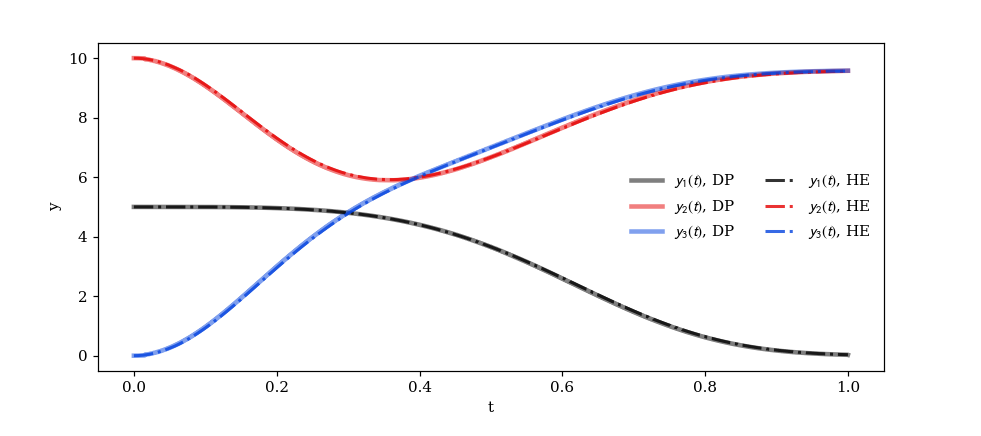

In [8]:
fig=plt.figure(figsize=(9,4))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(111)
for i in range(len(sol1.y)):
    sub.plot(sol1.t,sol1.y[i],c=_c[i],alpha=0.5,linestyle='-',linewidth=3,label=r'$y_{'+str(i+1)+'}(t)$, DP') 
    #sub.scatter(sol1.t,sol1.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  

for i in range(len(sol2.y)):
    sub.plot(sol2.t,sol2.y[i],c=_c[i],alpha=0.8,linestyle='-.',linewidth=2,label=r'$y_{'+str(i+1)+'}(t)$, HE') 
    #sub.scatter(sol1.t,sol1.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  
    
    
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,0.5))
sub.set_xlabel('t')  


plt.show()

<IPython.core.display.Javascript object>


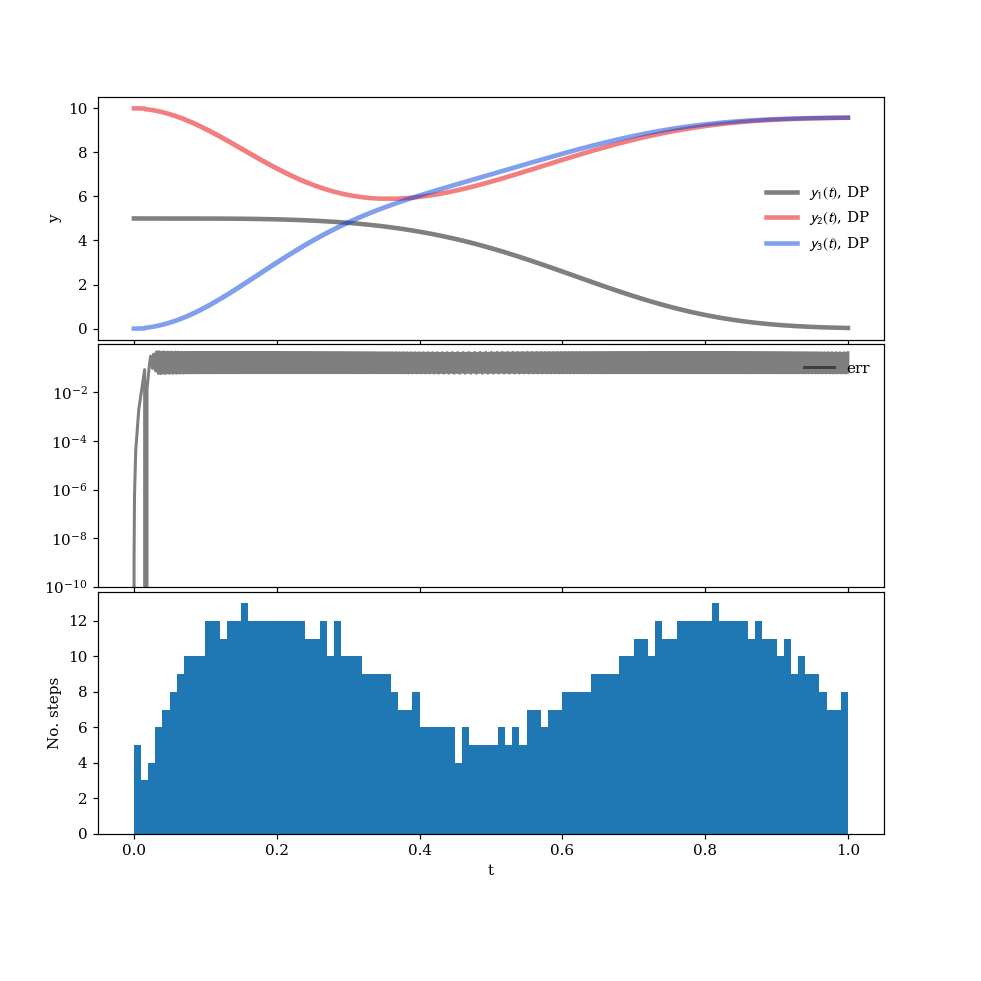

In [9]:
fig=plt.figure(figsize=(9,9))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.02)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(311)
for i in range(len(sol1.y)):
    sub.plot(sol1.t,sol1.y[i],c=_c[i],alpha=0.5,linestyle='-',linewidth=3,label=r'$y_{'+str(i+1)+'}(t)$, DP') 
    #sub.scatter(sol1.t,sol1.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  

sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,0.5))




sub = fig.add_subplot(312)    
sub.plot(sol1.t,sol1.deltas,c=_c[0],alpha=0.5,linestyle='-',linewidth=2,label="err")
sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,.9))

        
if max(sol1.deltas) != 0 : 
    sub.set_ylim(max([min(sol1.deltas),1e-10]),max(sol1.deltas)*2 )
    sub.set_yscale('log')
else:
    sub.set_ylim(min(sol1.deltas),max(sol1.deltas))



sub = fig.add_subplot(313)    
sub.hist(sol1.t,bins=100)
sub.set_ylabel('No. steps')
    
sub.set_xlabel('t')  


plt.show()

<IPython.core.display.Javascript object>


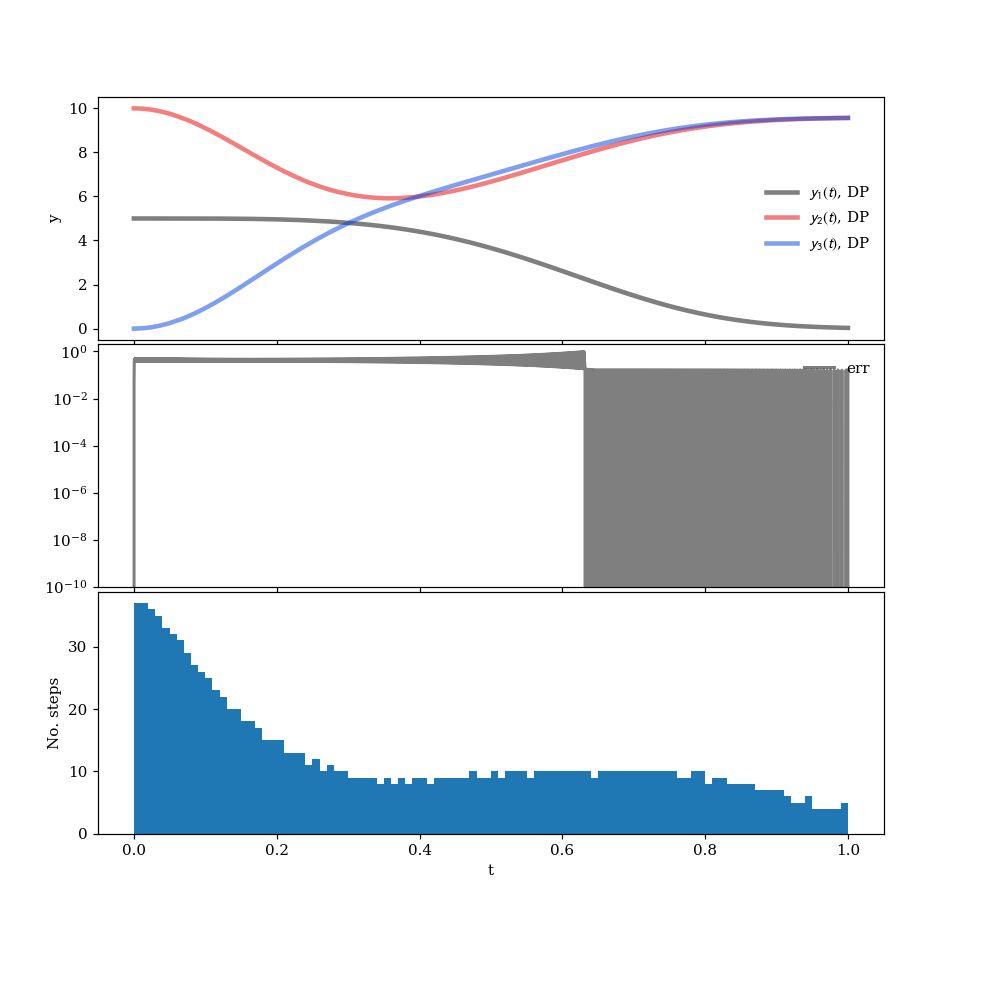

In [10]:
fig=plt.figure(figsize=(9,9))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.02)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(311)
for i in range(len(sol2.y)):
    sub.plot(sol2.t,sol2.y[i],c=_c[i],alpha=0.5,linestyle='-',linewidth=3,label=r'$y_{'+str(i+1)+'}(t)$, DP') 
    #sub.scatter(sol2.t,sol2.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  

sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,0.5))




sub = fig.add_subplot(312)    
sub.plot(sol2.t,sol2.deltas,c=_c[0],alpha=0.5,linestyle='-',linewidth=2,label="err")
sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,.9))

        
if max(sol2.deltas) != 0 : 
    sub.set_ylim(max([min(sol2.deltas),1e-10]),max(sol2.deltas)*2 )
    sub.set_yscale('log')
else:
    sub.set_ylim(min(sol2.deltas),max(sol2.deltas))



sub = fig.add_subplot(313)    
sub.hist(sol2.t,bins=100)
sub.set_ylabel('No. steps')
    
sub.set_xlabel('t')  


plt.show()